# Practice AI-2: （広義の）最良優先探索

**目次**
- [](Tutorial_3-sortable-data.ipynb)
- [](#Step-A5)
- [](#Step-A6)

**人工知能実験の目標（再掲）** &mdash; _The aim of AI experiment (Represent)_

迷路探索問題は，古典的な人工知能における典型的な問題の一つである．  
迷路探索に必要な探索処理は，適切な前提を置くことができれば，グラフ探索問題として解ける．

本実験では，迷路探索問題を解くためのプログラムを作成する．  
プログラムの実装を通して，**探索アルゴリズムの特徴を理解する**と同時に，**データ構造とアルゴリズムに対する理解を深める**ことを目指す．

**AI-2 の概要** &mdash; _Abstract (AI-2)_

第2回は，探索アルゴリズムの1つである，Dijkstra's algorithm を実装する．  
そのうえで，簡単な実験を通して，探索アルゴリズムの特徴（長所と欠点｜Pros.&Cons.）に関する理解を深める．

## AI-2の課題

別紙 ipynb に加筆して，以下の考察課題に対するレポートを作成してください．  
レポートの作成にあたっては，本紙の解説や練習問題等を参考にしながら，必要なプログラムの作成と考察をおこなってください．

:::{important} 課題 AI-2
迷路探索のためのグラフ探索として，Dijkstra’s algorithm の実装をおこない，その実装や実装方針について考察せよ．  
このとき，「深さ優先探索」あるいは「幅優先探索」のいずれかとの差分に注目し，探索過程や探索結果等も示しながら，考察すること．
:::

:::{dropdown} 考察課題（★発展★）　※任意課題
★発展 Level 1★  
基本の考察課題において，グリッド型迷路（[Extra-A](#ai-project-a)）に基づく独自の迷路を作り，
探索処理とBacktracking処理を関数化したうえで，考察する．

★発展 Level 2★  
さらに，いくつかの探索過程や探索結果も利用しながら，各探索方式（注：AI-1の方式も含む）が持つ特徴を比較・考察する．
「特徴」として，実装面に注目しても良いし，機能面に注目しても良い．（もちろん，両方含まれていても良い．）

```{dropdown} 発展 Level 2についての注意．
がむしゃらに迷路を増やして結果だけたくさん示しても，特に評価対象にはならない．
比較をするという目的を踏まえ，その目的に合致すると思われる迷路を仮説として複数用意し，それら迷路の探索結果を示す，
という「実験」の流れが必要である．
```
:::


In [1]:
# 本実験でほぼ毎回利用するライブラリ
import sys
import numpy as np

from IPython.display import display, Markdown

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["savefig.bbox"] = 'tight'

# データ構造の定義に利用する
from collections import deque
from dataclasses import dataclass

# グラフ構造の描画に利用するライブラリ
import networkx as netx

#
# DEBUG
#
print('*** System Information ***')
print(f'Python     : {sys.version}')
print(f'NumPy      : {np.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')
print(f'NetworkX   : {netx.__version__}')

*** System Information ***
Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy      : 2.3.2
Matplotlib : 3.10.5
NetworkX   : 3.5


In [2]:
%reload_ext autoreload
%autoreload 1
%aimport ebai

# 人工知能実験用の補助関数を定義したサブライブラリ（改変不可）
import ebai
ebai.ebai_info()
display(Markdown("**要確認：Revision 2025.1 以上が必要です**"))

/home/users/ecs/09B23523/exp-b/ai/ebai.py
> Revision 2025.1
> 更新日時：2025-10-03 11:18:05.715802
>
> Python     : 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
> NumPy      : 2.3.2
> Matplotlib : 3.10.5
> NetworkX   : 3.5


**要確認：Revision 2025.1 以上が必要です**

In [3]:
# PNGかPDFで画像を出力する
# - レポートPDFを作るときに，どうしても画像サイズが10 MB超える！という場合は，
#   ('png', 'pdf') を ('jpeg') のみに置き換えてから，試してみてください．
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

(Step-A5)=

## [解説A5] 迷路のコストと Weighted Adjacency List の定義

重み付きの隣接行列と同等の情報を持った隣接リストとして定義します．  
重みの数値は，迷路探索においては「あるマスからあるマスへ移動(進入)するために必要なコスト＝遷移コスト」です． 

以下に，Weighted Adjacency List の例 `graph3_edgedict` を示します．

In [4]:
## Graph3: (Weighted) Adjacency List (Edge dict)
#  - Note: Node no.0 is alwarys assumed as Source Node (= start of the maze) in this lecture.
#          You can select "entry point of the maze" by destination of Node no.0
graph3_edgedict = {
    0: [(1, 1.0)],
    1: [(2, 4.0), (3, 8.0)],
    2: [(1, 2.0), (4, 0.5)],
    3: [(1, 2.0), (4, 4.0), (5, 5.0)],
    4: [(3, 1.0)],
    5: [(3, 2.0)]
}
    # - 小数点を含む数値の場合，最初の 0 を省いて書くことがあります，
    #   （例：0.8 --> .8）プログラムソースコードの表記以外に，英語
    #   文献でもよく見かける表記です．覚えておいてください．
    
## Graph3: Target nodes: Node ID of Target node (=goal)
graph3_target = 5

## Graph3: Positions of nodes (for visualization)
graph3_pos = {
    0: [0, 0],
    1: [1, 1],
    2: [1, 2],
    3: [2, 1],
    4: [2, 2],
    5: [3, 1]
}

#
# DEBUG
#
print(f'DEBUG: graph3_edgedict =')
display(graph3_edgedict)
print(f'DEBUG: {graph3_target=}')
print(f'DEBUG: {graph3_pos=}')

DEBUG: graph3_edgedict =


{0: [(1, 1.0)],
 1: [(2, 4.0), (3, 8.0)],
 2: [(1, 2.0), (4, 0.5)],
 3: [(1, 2.0), (4, 4.0), (5, 5.0)],
 4: [(3, 1.0)],
 5: [(3, 2.0)]}

DEBUG: graph3_target=5
DEBUG: graph3_pos={0: [0, 0], 1: [1, 1], 2: [1, 2], 3: [2, 1], 4: [2, 2], 5: [3, 1]}


### Weighted Adjacency List のグラフとしての描画

オプションとして，`show_weight` を追加しています．

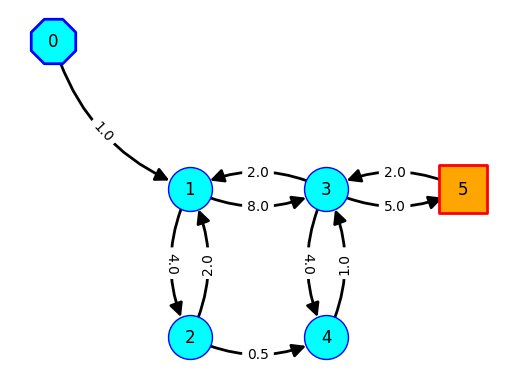

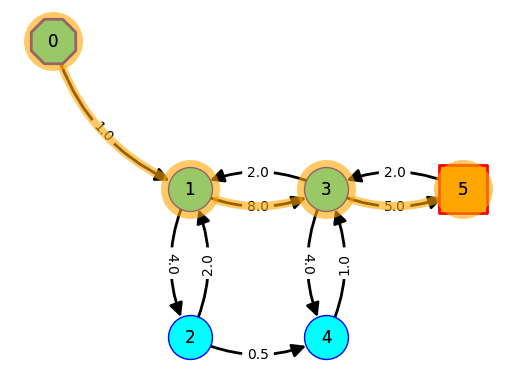

In [5]:
#
# draw the Weighted Graph
#
# -----------------------------------------------------------------
# Example 1: Draw the Graph
fig1, ax1 = plt.subplots()
ebai.draw_graph_structure(graph3_edgedict, graph3_pos, graph3_target,
                          show_weight=True,
                          ax=ax1)
# fig1.savefig('output/AI-2_graph3_example1.png', format='png')
# fig1.savefig('output/AI-2_graph3_example1.pdf', format='pdf')

# -----------------------------------------------------------------
# Example 2: Draw the Graph w/ hightlight path
fig2, ax2 = plt.subplots()
ebai.draw_graph_structure(graph3_edgedict, graph3_pos, graph3_target,
                          show_weight=True,
                          highlight_path=[0, 1, 3, 5],
                          ax=ax2)
# fig2.savefig('output/AI-2_graph3_example2.png', format='png')
# fig2.savefig('output/AI-2_graph3_example2.pdf', format='pdf')


### «PRACTICES»

:::{important} PRACTICE &star;　※考察不要
レポートでも，Graph3 の定義を行い，図示してください．（経路のハイライトは不要）
:::

:::{important} PRACTICE &star;　※考察不要
前回作成した Graph2 に適当な重みも与えた，Graph4 (`graph4_edgedict`, `graph4_target`, `graph4_pos`) を定義し，描画し，同じくレポートに掲載してください．  
(Graph4の重みは，各自で適当に与えてよい．ただし，少なくとも正の値にはすること．)
:::

DEBUG: graph4_edgedict =


{0: [(1, 1.0), (2, 2.0)],
 1: [(2, 3.0), (3, 4.0)],
 2: [(1, 3.0), (4, 2.0)],
 3: [(1, 1.0), (4, 5.0), (5, 4.0)],
 4: [(2, 3.0), (3, 3.0), (6, 2.0)],
 5: [(3, 5.0)],
 6: [(4, 1.0), (7, 1.0)],
 7: [(5, 1.0)]}

DEBUG: graph4_target=5
DEBUG: graph4_pos={0: [0, 1], 1: [1, 2], 2: [1, 0], 3: [2, 1], 4: [2, 0], 5: [3, 1], 6: [3, 0], 7: [4, 0.5]}


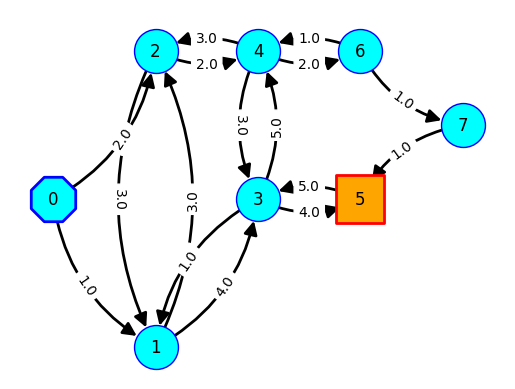

In [37]:
## Graph4 Definition
# Weighted Adjacency List
graph4_edgedict = {
    0: [(1, 1.0), (2, 2.0)],
    1: [(2, 3.0), (3, 4.0)],
    2: [(1, 3.0), (4, 2.0)],
    3: [(1, 1.0), (4, 5.0), (5, 4.0)],
    4: [(2, 3.0), (3, 3.0), (6, 2.0)],
    5: [(3, 5.0)],
    6: [(4, 1.0), (7, 1.0)],
    7: [(5, 1.0)]
}

# Target node
graph4_target = 5

# Positions of nodes
graph4_pos = {0: [0, 1], 1: [1, 2], 2: [1, 0], 3: [2, 1], 4:[2, 0], 5:[3, 1], 6: [3, 0], 7: [4, 0.5]}

# Draw the Graph
fig4, ax4 = plt.subplots()
ebai.draw_graph_structure(graph4_edgedict, graph4_pos, graph4_target,
                          show_weight=True,
                          ax=ax4)

#
# DEBUG
#
print(f'DEBUG: graph4_edgedict =')
display(graph4_edgedict)
print(f'DEBUG: {graph4_target=}')
print(f'DEBUG: {graph4_pos=}')

(Step-A6)=

## [解説A6] Dijkstra's algorithm による最適経路探索

前回の内容を踏まえて，オープンリストとして Priority Queue を採用したグラフ探索の実装を完成させましょう．

ヒープデータ構造を利用した (Unique-constrained) Priority Queue は，[別紙 Tutorial 3](Tutorial_3-sortable-data.ipynb) で説明しました．  
探索におけるオープンリストの扱いを理解できていれば，数か所を書き換えるだけで完成することはわかるはずです．

実装のポイントは2点です．

**ポイント1: 探索過程における状態ノード(State)に適切なコスト値を与える**

  - 基本的な処理はスライドで説明しており，例題も示している．（参照：スライド#49-51）
    - 「ノード $n_i$ からノード $n_{i+1}$ への遷移コスト $c(n_i, n_{i+1})$」は，
      Weighted Adjacency Matrix (または，Weighted Adjacenty List) から得られる（参照：スライド#56）
    - 候補ノードが持つべき「累積コスト $g(n_{i+1})$」は，現ノードが持つ「累積コスト $g(n_i)$」と
      「遷移コスト $c(n_i, n_{i+1})$」の和，  
      すなわち， $g(n_{i+1}) \leftarrow g(n_i) + c(n_i, n_{i+1})$ である．（参照：スライド#49）
  - プログラムの基本構造は，すでに前回の資料で理解をしており，変更の要点も説明済みである（解説A2）
    - `open_list` から取り出される状態 `cur_state` の `cost` メンバには，スタートからその状態に至るまでの累積コスト $g(n)$ が格納されている必要がある．
    - そのためには，`open_list` に「追加」する時点で，候補ノードが適切なコスト計算に基づくコストを持つ必要がある．

**ポイント2: オープンリストのデータ構造として，Unique-constrained Priority Queue を使う**

  - 前回実装における (7-2) open_list への既存判定に注意しよう．
  - [Tutorial 3](Tutorial_3-sortable-data.ipynb) で示した Unique-constrained Priority Queue は，「(7-2) open_list の既存判定 + Priority Queue」としての動作を示している．


:::{note} 参考：「人工知能」の探索と「アルゴリズム論（データ構造とアルゴリズム）」の探索
:class: dropdown

本資料は人工知能の資料に沿った解説をしています．

アルゴリズム論の6.5章（pp.118--122) に「ダイクストラの最短経路アルゴリズム」が掲載されていますが，
本資料のアルゴリズムとは若干の差があるように見えると思います．

アルゴリズム論の図6.10との対比をすると，

- $X$ の◎ ... (open_list から pop した) current_state
- $X$ の○と× ... closed_list (あるいは，その key の有無)
- $D$ ... closed_list と open_list の和集合（closed_list優先）

のようなものです．そして，$X$の×の集合から$\min(D)$を探す処理は，
本資料では Priority Queue として最小値を保持する方針に関する話題と関連します（see also: p.122の最終段落）．

:::

### «PRACTICES»

:::{important} PRACTICE &star;

- Priority Queue を利用して，Dijkstra's algorithm によるグラフ探索処理を1つのセルで完結させ，レポートに記載してください．
  - Backtracking の結果も示してください．
- 前回の Queue を利用した実装と比べて，Unique-constrained Priority Queue を利用した実装で，探索アルゴリズムがどのように変化したのか．説明してください．
  - コストを考慮した場合とコストを考慮しない場合，という視点でも構わない．

> &starf;発展&starf;
> Queue による探索（コストを考慮しない探索）と Unique-constrained Priority Queue による探索（コストを考慮した探索）の違いを示すなら，  
> その差が分かりやすいグラフ構造を用意して説明すべきであろう．グラフを1つに限る必要もない．
>
> 例えば，`ebai.MazeGraph()` を使うと，迷路のようなグラフをある程度簡単に作成できる．[Extra_AI-1](Extra_AI-1.ipynb)で説明しているので参考にしてほしい．

:::

In [39]:
import heapq
@dataclass
class State:
    """
    Parameters
    ----------
    id: int
        ロボットが現在居る場所．探索したいグラフのノード番号で指定する．
        Adjacency Matrix/List の番号と相互参照できるものとする．

    cost: float
        探索過程におけるノードのコスト g(n)

    parent_id: int
        現在位置に至る1つ前の時点で滞在していた場所．ノード番号で指定する．
        値が負のとき，親ノードは存在しないこととする．

    Note
    ----
    - AI-1の時点では，コストは使わない．次回の「知識のある探索」で利用する．
      - ただし，発展として使っていても差し支えはない．
    - AI-1の時点では，比較関数を実装していないためソートできない
      (AI-2/Tutorial_3 で解決する)
    """
    
    id: int
    cost: float
    parent_id: int
    def __lt__(a, b):
        if a.cost != b.cost:
            return a.cost < b.cost
    
# Parameters
graph_edgedict = graph4_edgedict
graph_target = graph4_target
graph_pos = graph4_pos

(1) open_list=[State(id=0, cost=0, parent_id=-1)]
(1) closed_list={}

----- LOOP = 1
(3) cur_state=State(id=0, cost=0, parent_id=-1)
(3) open_list=[]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1)}
(6) candidate_state_nodes=[(1, 1.0), (2, 2.0)]
(7) open_list=[State(id=1, cost=1.0, parent_id=0), State(id=2, cost=2.0, parent_id=0)]

----- LOOP = 2
(3) cur_state=State(id=1, cost=1.0, parent_id=0)
(3) open_list=[State(id=2, cost=2.0, parent_id=0)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0)}
(6) candidate_state_nodes=[(2, 3.0), (3, 4.0)]
(7) open_list=[State(id=2, cost=2.0, parent_id=0), State(id=3, cost=5.0, parent_id=1)]

----- LOOP = 3
(3) cur_state=State(id=2, cost=2.0, parent_id=0)
(3) open_list=[State(id=3, cost=5.0, parent_id=1)]
(4) closed_list={0: State(id=0, cost=0, parent_id=-1), 1: State(id=1, cost=1.0, parent_id=0), 2: State(id=2, cost=2.0, parent_id=0)}
(6) candidate_state_nodes=[(1, 3.0), (4, 2.0)]
(7) open_list=[State(

{0: State(id=0, cost=0, parent_id=-1),
 1: State(id=1, cost=1.0, parent_id=0),
 2: State(id=2, cost=2.0, parent_id=0),
 4: State(id=4, cost=4.0, parent_id=2),
 3: State(id=3, cost=5.0, parent_id=1),
 6: State(id=6, cost=6.0, parent_id=4),
 7: State(id=7, cost=7.0, parent_id=6),
 5: State(id=5, cost=8.0, parent_id=7)}

TEST BACKTRACKING --------
DEBUG: bt_node_id=5
DEBUG: route=deque([5])
DEBUG: bt_node_id=7
DEBUG: route=deque([7, 5])
DEBUG: bt_node_id=6
DEBUG: route=deque([6, 7, 5])
DEBUG: bt_node_id=4
DEBUG: route=deque([4, 6, 7, 5])
DEBUG: bt_node_id=2
DEBUG: route=deque([2, 4, 6, 7, 5])
DEBUG: bt_node_id=0
DEBUG: route=deque([0, 2, 4, 6, 7, 5])
DEBUG: bt_node_id=-1
Backtracking: Success: Route = [0, 2, 4, 6, 7, 5]

-----


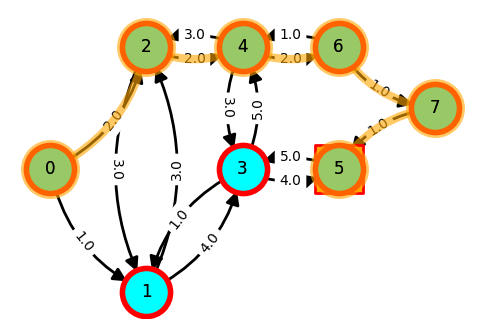

In [40]:
# Write your code
# (1) Initialization
# (1-1) Prepare open_list as STACK, QUEUE, or XXXX(AI-2)
open_list = []
heapq.heapify(open_list)
# - 任意のリストは heapify を経ることで heap として扱えるようになります．
heapq.heappush(open_list, State(0, cost=0, parent_id=-1))
    # - open_list は "List(deque) of State" とする．
    #   - [] の中に State() を1つだけ入れており，そのリストで deque を初期化している．
    # - スタートは常に0番ノードにする．
    #   - いったんはcost = 0, parent_id = -1 ということにしておく．
    #   - 【重要】cost と parent_id は後で見直しが必要．

# (1-2) Prepare closed_list as DICT
closed_list = dict()
    # - closed_list は "Dict of State" とする．
    # - cf. This implementaion by dict might be easy and simple one.
    #       However, an implementation by list (static table) might
    #       be faster. As some algorithm contest, the dict implementation
    #       will be caused TLE (Time Limit Exceed)...

# DEBUG
print(f'(1) {open_list=}')
print(f'(1) {closed_list=}')


# ---------------------------------------------------------------------------
# (2) Loop until the open_list is empty
#     (Loop while(if) the open_list is not empty)
loop_count = 0
while len(open_list) > 0 and loop_count < 100:
    # - open_listに要素がある限り，ループし続ける
    # - 安全のため，loop_count が増えすぎてるなら，タイムアウトとして止める．
    #   **初期の100では，探索対象のグラフによっては少なすぎるかもしれないので，注意．**
    # - なお，例年 while 文が苦手という人がいるようですが・・・
    #   while文は，if文とほぼ同じです．条件が成立するなら内部を実行する，です．
    #   ただし，if文は内部を実行終えたら，そこで終わるが，while文は条件判定に戻る．
    #   cf. アセンブラで言えば，if でも while でも，beqによる条件分岐があるのは同じだが，
    #       while は最後に j whie_loop を置くことでループ構造を実現する．
    #       https://www.swlab.cs.okayama-u.ac.jp/~nom/lect/p3/dat/examples/ans-practice5-1.s 

    loop_count += 1;
    print(f'\n----- LOOP = {loop_count}')

    # -----------------------------------------------------------------------
    # (3) Set current state for search algorithm
    cur_state = heapq.heappop(open_list)   # POP as STACK

    #     DEBUG
    print(f'(3) {cur_state=}')
    print(f'(3) {open_list=}')

    # -----------------------------------------------------------------------
    # (4) Update closed_list
    assert cur_state.id not in closed_list, f'REVISITED: {cur_state.id=} should not in {closed_list=}'
        # - assert は条件を満たしていないときに処理を止める関数です
        #   - アルゴリズムとして必要なのではなく，検証 (validation) の一種です．
        # - 後述の (7-1) や (7-2) で適切な処理をしていない場合は，
        #   ここで "再訪(revisit)" してしまう場合があります．
        #   - "再訪" になってしまう場合は，ここで処理を加えるよりは (7) を見直しましょう．
        # - ただし・・・どうしても解決できない（か，独自に考えているアルゴリズムであり，
        #   ここでの再訪相当を適切に処理することにした）なら，この assert を除いてください．
        #   - それはそれで，考察できることは増えると思いますので．．．

    closed_list[cur_state.id] = cur_state
        # - closed_list に記録を残します．
        # - 本講義で想定しているアルゴリズムであれば，ここでは上書きは起こりません．
        #   - 上述の通り，アルゴリズムによっては，何らかの条件分岐が必要かもしれません．

    #     DEBUG
    print(f'(4) {closed_list=}')

    # -----------------------------------------------------------------------
    # (5) Check whether reaching the target (goal) or not
    if graph_target in closed_list:
        # Python の独特な条件式です．graph_target と一致する要素が，
        # closed_list のキーに含まれているかどうかのチェックをしています．

        print('\n**** I have reached the target node!!\n')
        break
            # この終了条件は，今後必要に応じて見直しが必要になるでしょう．
            # 【発展】ここで終了しなくても，解説A3の経路探索は実現できる．
            #         （終了すべきでない，とまでは言っていません．考察課題です．）

    # -----------------------------------------------------------------------
    # (6) Find adjacent nodes
    candidate_state_nodes = graph_edgedict[cur_state.id]
        # - cur_stateのノードの隣接ノードは，graph_edgedict を辞書引きすればよい
        # - この時点では candidate_state_nodes は (dst_id, weight) のタプルである．

    #     DEBUG
    print(f'(6) {candidate_state_nodes=}')

    # -----------------------------------------------------------------------
    # (7) Update open_list
    for _dst_id, _weight in candidate_state_nodes:
        candidate_state = State(
            id=_dst_id,
            cost=_weight + cur_state.cost,       # TODO: 解説A5 & A6 (AI-2)
            parent_id=cur_state.id  # TODO: 解説A3
        )
            # - for ループを使い，候補となるノードを追加したい．効率は無視．
            #   - 候補となるノードは，[解説A2]時点では，id (ノードID)しか情報を持っていない．
            #   - parent_id は，次の[解説A3]で考え直す必要がある．
            #   - cost は，AI-2で考え直す必要がある．
            # - 以降，_candidate_node を open_list に追加してよいかどうか，
            #   を判定してから，最終的に，open_list へ追加する．

        # (7-1) Ignore the candidate, if it existing in closed _list
        #   Note: We should reconsider this process, if try to implement A* algorithm
        if candidate_state.id in closed_list:
            continue
                # - closed_list は dict 型なので in 演算子で存在の判定ができる
                # - _dst_id が探索済みのノード（closed_list内のノード）である
                #    ==> open_listには追加しない．
                #    ==> "continue" により，以降の処理は実行せず，forループを継続する

        # (7-2) Ignore the candidate, if it existing in open_list
        #   Note: We must reconsider this process at AI-2
        _exist_state = [x for x in open_list if x.id == candidate_state.id]
        _exist_state = _exist_state[0] if _exist_state else None
        if _exist_state is None:
                # - 本講義だけでは，この3行の条件判定の解説は難しいので，深入りしないで構いません．
                # - この処理では，open_list 内の全探索状態に candidate_state.id と同じIDがあれば，
                #   _exist_state として，open_list の1要素が得られます．無ければ None です．

            heapq.heappush(open_list, candidate_state)

        elif candidate_state.cost < _exist_state.cost:
            open_list.remove(_exist_state)
            open_list.append(candidate_state)
            heapq.heapify(open_list)
        else:
            pass
                # - open_list に _dst_id と同じ id の状態データが存在する
                #    ==> (AI-1では) open_listには追加しない．
                #
                # 【重要】AI-2で cost も踏まえた再検討をする．次回のTutorial 3 も注意深く確認しよう．

    print(f'(7) {open_list=}')

# -----------------------------------------------------------------------


#
# Backtracking
#
def backtrack(closed_list, graph_target, graph_start):
    """ BACKTRACK
    PARAMETERS
    ----------
    closed_list
        グラフ探索で得られたクローズドリスト
    graph_target
        グラフ探索におけるゴールとなるノードのID
    graph_start (default: 0)
        グラフ探索におけるスタートとなるノードのID

    RETURNS
    -------
    ????
        ????
    ????
        ????

    NOTE
    ----
    - return は各自で考えよう．
      - 何も戻さない方針なら return 文をなくして，上記 RETURNS については，None とでも書いておけばよい
    """
    # parameters
    route = deque([])
        # - route にノード情報を追加していく．
        # - 追加と利用の考え方は，システムプログラミングの関数呼び出しにおけるスタックと同じ考え方．
    
    bt_node_id = graph_target
        # - ゴールから逆にたどるので，ゴールのノード番号を入れておく
        # - bt は backtracking の略です．
    
    # Debug
    print(f'DEBUG: {bt_node_id=}')
    while bt_node_id >= 0:
        # - 本資料では，ソースノードは，常に0番ノードと仮定していることを思い出そう．
        #   - ソースノードは，Backtracking 処理におけるゴールに相当する．
        # - != 0 でも問題はないが・・・もう少し考えてみよう
        #   - 実際のところ，（正常な）ノードID としては，正の値しか使っていない．
        #   - そこで，先を見越して，広く設定しておこう．この条件ならば「正常でない」の意味で，
        #     マイナス番号のノードIDをプログラマが意図的に利用することもできる．
    
        route.appendleft(bt_node_id)
            # - 先頭に追加していく．
    
        # Debug
        print(f'DEBUG: {route=}')
    
        bt_node_id = closed_list.get(bt_node_id, State(id=-1, cost=-1, parent_id=-9)).parent_id
            # - dict.getは，辞書引きをする際にkeyが見つからなければ，第2引数をdefault値としてを返す
    
        # Debug
        print(f'DEBUG: {bt_node_id=}')
    
    if bt_node_id <= graph_start:
            # ⇒ a) Backtracking 成功は，どんな条件になるでしょうか？
            #   自分でif文を書き換えてください．
        # Backtracking 成功
        print(f'Backtracking: Success: Route = {list(route)}')
    else:
        # Backtracking失敗
        print(f'Backtracking: Failed: Route = {list(route)}?')

    # Debug
    print('\n-----')

    return list(route)
            # ⇒ b) 何を返すのがよいか，は自分でよく考えてください．
            #       （何も返さないという方針も当然あり得ますが，考えを示す必要があります．）

#
# Test your function
#
print(f'DEBUG: {graph_target=}')
display(closed_list)
    # - 探索"成功"時の closed_list を使います．セルの中でも，簡単に中身を確認しておくといいでしょう．
    # - なお，"成功"していないときの動作は，未定義です．所望のBacktrackingの結果は得られないでしょう．

print('TEST BACKTRACKING --------')
true_rute = backtrack(closed_list, graph_target, 0)
    # - 関数のデバッグをしたいなら，右サイドバーの虫アイコンを押して，デバッガを起動し，
    #   ブレークポイント設置とステップ実行をするとよいでしょう．

# DEBUG: draw the Graph
ebai.draw_graph_structure(graph_edgedict, graph_pos, graph_target, open_list=open_list,
                          show_weight=True,
                          highlight_path=true_rute,
                          closed_list=closed_list)
    # - 先ほどの描画例に加えて，open_list, closed_list も追加している
    #   - 適宜，引数を与えずに描画するなどして，描かれた図の各シンボルが
    #     何を表しているのか，理解をしてください．
    # - ループ込みの完成版であれば，ループ内で毎回描画するのは，無駄である．
    #   必要な場所でのみ，描画すれば十分であろう．
    # **********
    # 【注意】
    # fig?.savefig()を利用した画像保存をする際は，十分に注意を払ってください．
    # ループ内での savefig() 呼び出しは，大量のネットワーク経由のデータ転送と，
    # 共有ディスクの大量消費をする可能性があり，ほかの学生の受講の妨げになります．
    # （あなたの端末だけでなく，演習室の全端末がハングアップする可能性があります．）
    # **********

# Show the Result of Backtracking

:::{attention}
AI-2の課題はここまでです．

発展課題に熱中しすぎて，レポート執筆を忘れないようにしてください．  
最終的に整理されたレポートの締め切りは，本課題の実施日から1週間後としています．  
ただし，**次回の午前中のうちに，最終的なレポートとして提出している**ことが望ましいです．

次回，3-4限は音声実験の導入，5-7限は画像実験の導入，になります．
:::